Procesamiento del Lenguaje Natural

Rodrigo S. Cortez Madrigal

<img src="https://pcic.posgrado.unam.mx/wp-content/uploads/Ciencia-e-Ingenieria-de-la-Computacion_color.png" alt="Logo PCIC" width="128" />  

In [1]:
import stanza
import spacy
import transformers

import matplotlib.pyplot as plt
import networkx as nx

/opt/homebrew/Caskroom/miniforge/base/envs/NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Queremos analizar la sigueinte cadena de texto

text = "My father likes to play chess. I usually play with him, but when he is not home, I play with my sister. She is a good player."

### Utilizando Stanza para Correferencia

In [3]:
pipe = stanza.Pipeline("en", processors="tokenize,coref")

2025-03-18 22:51:47 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-03-18 22:51:47 INFO: Downloaded file to /Users/roicort/stanza_resources/resources.json
2025-03-18 22:51:47 WARNING: Language en package default expects mwt, which has been added
2025-03-18 22:51:48 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | combined                 |
| mwt       | combined                 |
| coref     | udcoref_xlm-roberta-lora |

2025-03-18 22:51:48 INFO: Using device: cpu
2025-03-18 22:51:48 INFO: Loading: tokenize
2025-03-18 22:51:48 INFO: Loading: mwt
2025-03-18 22:51:48 INFO: Loading: coref
2025-03-18 22:51:51 INFO: Done loading processors!


When used in a pipeline, the coreference found will be attached at the [Document](/stanza/data_objects.html#document) level. The format is a sequence of CorefChain objects, where each CorefChain includes one or more CorefMention objects. See coref_chain.py for more information. The Word objects each have a field coref_chains which is a list of CorefAttachment objects. Those link back to the relevant chain and mark whether or not this is the representative mention.

The representative mention is chosen by taking the longest mention in a chain, ties broken by earliest in the document.

In [4]:
doc = pipe(text)
print("{:C}".format(doc))

# text = My father likes to play chess.
# sent_id = 0
1	My	_	_	_	_	0	_	_	start_char=0|end_char=2|coref_chains=unit-repr-id0,start-repr-id1
2	father	_	_	_	_	1	_	_	start_char=3|end_char=9|coref_chains=end-repr-id1
3	likes	_	_	_	_	2	_	_	start_char=10|end_char=15
4	to	_	_	_	_	3	_	_	start_char=16|end_char=18
5	play	_	_	_	_	4	_	_	start_char=19|end_char=23
6	chess	_	_	_	_	5	_	_	start_char=24|end_char=29|coref_chains=unit-repr-id2|SpaceAfter=No
7	.	_	_	_	_	6	_	_	start_char=29|end_char=30

# text = I usually play with him, but when he is not home, I play with my sister.
# sent_id = 1
1	I	_	_	_	_	0	_	_	start_char=31|end_char=32|coref_chains=unit-id0
2	usually	_	_	_	_	1	_	_	start_char=33|end_char=40
3	play	_	_	_	_	2	_	_	start_char=41|end_char=45
4	with	_	_	_	_	3	_	_	start_char=46|end_char=50
5	him	_	_	_	_	4	_	_	start_char=51|end_char=54|coref_chains=unit-id1|SpaceAfter=No
6	,	_	_	_	_	5	_	_	start_char=54|end_char=55
7	but	_	_	_	_	6	_	_	start_char=56|end_char=59
8	when	_	_	_	_	7	_	_	start_char=60|e

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

class corefViz:
    def __init__(self, doc):
        self.doc = doc
        self.G = nx.DiGraph()
        self.pos = None

    def create_graph(self):
        for sentence_id, sentence in enumerate(self.doc.sentences):
            for token in sentence.tokens:
                tokendict = token.to_dict()[0]
                # Agregar el atributo 'sentence_id' para identificar la oración
                self.G.add_node(tokendict['id'], label=tokendict['text'], sentence_id=sentence_id, **tokendict)
                for d in [dict(j.to_json()) for j in tokendict['coref_chains']]:
                    self.G.add_node(d['index'], label=d['representative_text'], sentence_id=sentence_id, **d)
                    self.G.add_edge(d['index'], tokendict['id'])  # Agregar arista dirigida

    def linear_pos(self, G):
        # Ordenar los nodos por su ID antes de asignar posiciones
        sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[0])  # Ordenar por ID del nodo
        for i, (node_id, _) in enumerate(sorted_nodes):
            G.nodes[node_id]['pos'] = (i + 100, i + 100)
        return nx.get_node_attributes(G, 'pos')

    def draw_graph(self):
        plt.figure(figsize=(10, 10))

        # self.pos = nx.spring_layout(self.G)  # Diseño por defecto
        # self.pos = nx.circular_layout(self.G)  # Diseño circular
        self.pos = nx.shell_layout(self.G)  # Diseño en capas concéntricas
        # self.pos = nx.kamada_kawai_layout(self.G)  # Diseño basado en energía
        # self.pos = nx.spring_layout(self.G)

        # Asignar colores a los nodos según el atributo 'sentence_id'
        sentence_ids = nx.get_node_attributes(self.G, 'sentence_id')
        unique_sentences = list(set(sentence_ids.values()))
        color_map = {sentence_id: plt.cm.tab10(i) for i, sentence_id in enumerate(unique_sentences)}
        node_colors = [color_map[sentence_ids[node]] for node in self.G.nodes]

        # Dibujar el grafo dirigido
        nx.draw(self.G, self.pos, with_labels=False, node_size=300, node_color=node_colors, font_weight="bold", arrows=True)

        # Dibujar las etiquetas de los nodos
        labels = nx.get_node_attributes(self.G, 'label')
        nx.draw_networkx_labels(self.G, self.pos, labels, font_size=10, font_color="black")

        plt.title("Visualización de cadenas de correferencia (Colores por oración)")
        plt.show()

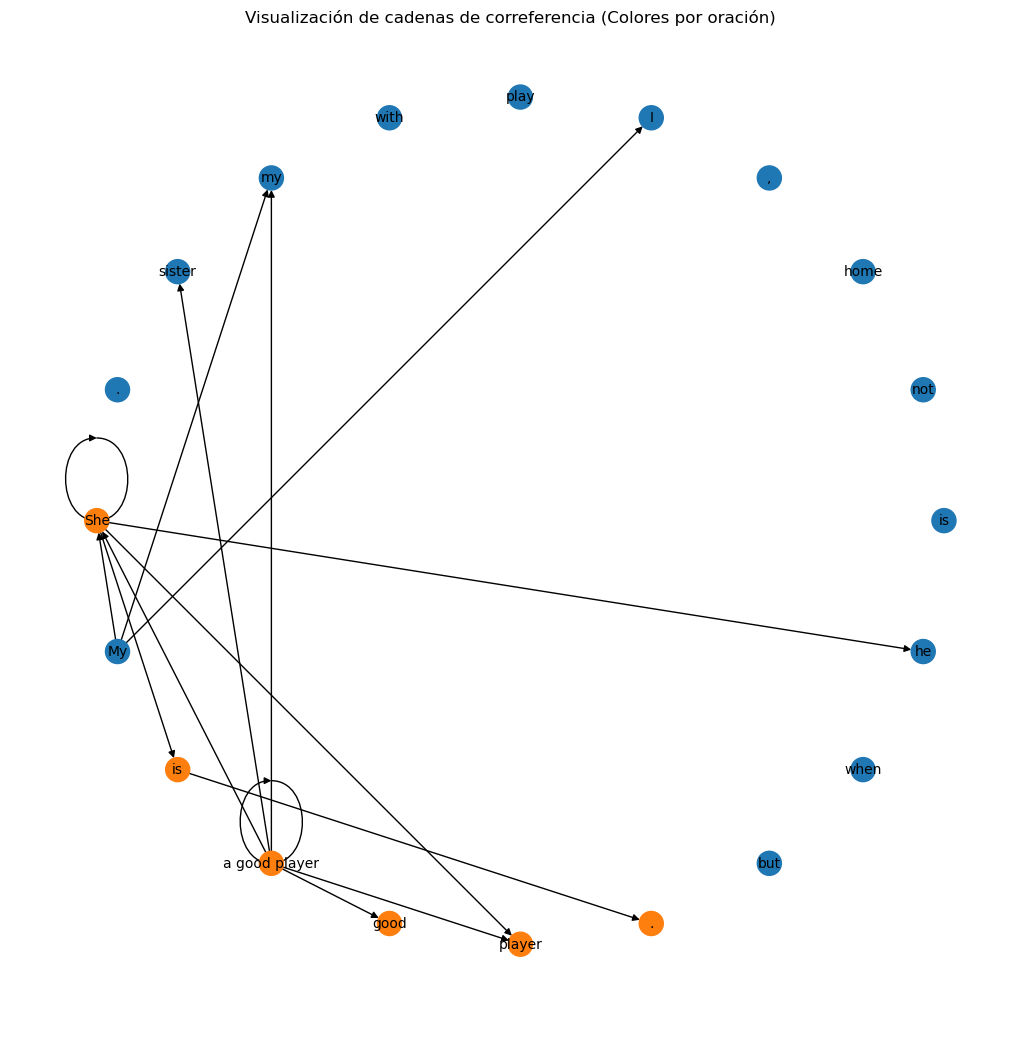

In [34]:
viz = corefViz(doc)
viz.create_graph()
viz.draw_graph()